In [1]:
from eplus_ga import eppy_funcs as ef
from eplus_ga import sampling
from eplus_ga import objectives

from eplus_ga.problem import EPProblem
from eplus_ga.evaluator import EvaluatorEP

from sklearn import gaussian_process
from sklearn.model_selection import train_test_split

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from eplus_ga.parameters import RangeParameter, CategoryParameter, expand_plist

# Gaussian Process Template
A Gaussian Process is a collection of random variables such that every every finite linear combination of those variables is normally distributed.

A Gaussian Process is useful when working with smaller samplesets and can be optimized exactly when given the proper values for it's hyperparameters, but is less optimal than a Neural Network when working with non-smooth/complicated functions on extremely large data sets.

Before we can start creating the model and fitting data to it, we have to initialise all of the necessary EPlus variables, which include:

* The building we are modifying
* What parameters we want to modify
* The type of problem we are solving for
* The samples that we plan to use

More info can be found on these from the jupyter notebooks inside of the "Polished Examples" folder.

In [2]:
building = ef.get_building()

parameters = expand_plist(
    {'Mass NonRes Wall Insulation':
        {'Thickness': (0.01, 0.99)},
    'NonRes Fixed Assembly Window':
        {'U-Factor':(0.1,5)}
    }
)

problem = EPProblem(parameters, ['Electricity:Facility'])

samples = sampling.dist_sampler(sampling.seeded_sampler, problem, 500)

With those variables made we can then create the EPlus evaluator and use that to get our outputs, which we will be using to train and test our machine learning model

In [3]:
evaluator = EvaluatorEP(problem, building)

outputs = evaluator.df_apply(samples)

Now with all of that out of the way we can start on making our machine learning model.

Firstly we need to split the data into training data and testing data, which will be used to test:

In [4]:
train_in, test_in, train_out, test_out = train_test_split(samples, outputs, test_size=0.2)

Next we need to initiate the machine learning model we want to use, in this case we are using a Gaussian Process:

In [5]:
reg = gaussian_process.GaussianProcessRegressor()

For a list of the parameters that can be tweaked go to: [here](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html)

Afterwards we just need to calibrate the model by giving it the training input and the output data that we got before:

In [6]:
reg.fit(train_in, train_out)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

And with that we will have our results:

In [20]:
results = test_in.copy()
results['Energy Use'] = test_out
results['Predicted'] = reg.predict(test_in)

results.head()

Thickness  U-Factor    Energy Use     Predicted
289   0.447467  4.548590  1.847724e+09  1.851041e+09
336   0.612237  0.443207  1.833416e+09  1.832231e+09
116   0.517837  0.225747  1.836932e+09  1.836934e+09
305   0.457389  1.753639  1.826918e+09  1.827069e+09
135   0.967945  4.394876  1.842166e+09  1.841994e+09

If we want to check our accuracy with the R^2 value we can see it using score():

In [8]:
r_2 = reg.score(train_in, train_out)
r_2

0.9966594227135706

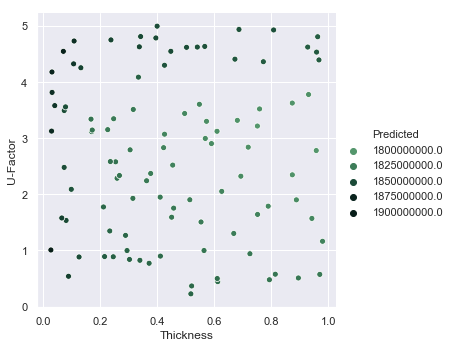

In [21]:
import seaborn as sns
sns.set(style="darkgrid")
sns.relplot(x="Thickness", y="U-Factor", hue="Predicted", palette="ch:2.5,-.2,2,l=.7,d=.3", data=results);